In [2]:
!date

Sat Jun 12 00:16:14 MDT 2021


creating gdf_ccvls:  ccvl_2014_05_15_23_lat6p137N = gdf_ccvls.iloc[0:1]
time level is  -2
time is:  2014-05-15T22:00:00.000000000
Step 3 appending:  ccvl_2014_05_15_23_lat6p137N = ccvl_2014_05_15_23_lat6p137N.append(gdf_ccvls_now.iloc[0:1])
time level is  -3
time is:  2014-05-15T21:00:00.000000000
Step 3 appending:  ccvl_2014_05_15_23_lat6p137N = ccvl_2014_05_15_23_lat6p137N.append(gdf_ccvls_now.iloc[0:1])
time level is  -4
time is:  2014-05-15T20:00:00.000000000
Step 3 appending:  ccvl_2014_05_15_23_lat6p137N = ccvl_2014_05_15_23_lat6p137N.append(gdf_ccvls_now.iloc[0:1])
time level is  -5
time is:  2014-05-15T19:00:00.000000000
Step 3 appending:  ccvl_2014_05_15_23_lat6p137N = ccvl_2014_05_15_23_lat6p137N.append(gdf_ccvls_now.iloc[0:1])
time level is  -6
time is:  2014-05-15T18:00:00.000000000
Step 3 appending:  ccvl_2014_05_15_23_lat6p137N = ccvl_2014_05_15_23_lat6p137N.append(gdf_ccvls_now.iloc[0:1])
time level is  -7
time is:  2014-05-15T17:00:00.000000000
Step 3 appending:  ccvl_2

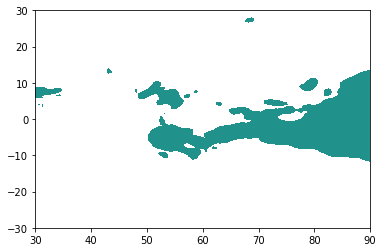

In [43]:
# Backward time loop to track coast-crossing vapor lakes (CCVLs)
### using Geopandas methods from Geopandas_overlaps.ipynb

### tag format is `yyyymmddhh_at_coast.meanlat`

# where meanlat is the mean latitude of the overlap with a coastline 

from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os         

from glob import glob
import xarray as xr

import pandas as pd
import geopandas as gp
from datetime import datetime

# A function to return a GeoDataFrame of polygons 
# loop over contour collections (and polygons in each collection)
# store in polylist  
def gdf_from_contours(lon,lat,tqv,conlevel):
    
    levels = [conlevel, 9e9]
    cs = plt.contourf(lon,lat,tqv,levels)
# create lookup table for levels
    lvl_lookup = dict(zip(cs.collections, cs.levels))
    
    zvalues, polylist  = [], []
#    i=0
    for col in cs.collections:
        z=lvl_lookup[col] # the value of this level
        for contour_path in col.get_paths():
#        print('contour path: ',i); i = i+1
        # create the polygon for this level
            for ncp,cp in enumerate(contour_path.to_polygons()):
#            print('   ncp: ', ncp)
                lons = np.array(cp)[:,0]
                lats = np.array(cp)[:,1]
                new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
                if ncp == 0:
                    poly = new_shape # first shape
                else:
                    poly = poly.difference(new_shape) # Remove the holes

            polylist.append(poly)
            zvalues.append(z)
        
        gdf = gp.GeoDataFrame(geometry=polylist)
        gdf['tqv_values']=zvalues
        gdf['area']=gdf.area
        gdf['maxlon']=gdf.bounds.maxx
        return(gdf)

gdf_litt = gp.read_file('Africa_Ecoast_20NS.geojson')
#gdf_litt.plot()


# Open the virtual (time series) dataset in xarray

files = glob('MERRA2*.nc') #+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one
cwv_WEIO = cwv_data.sel(lat=slice(-30,30),lon=slice(30,90))

# To initialize the cycle, process the last-most time (index -1) to a gdf

ccvls_stats = [] # empty, to collect the stats of ccvls

# dest means destined, the future time level in a reverse time loop
# Initially, it is the -1 element of the data, and we need a first coast-overlap test
gdf_dest = gdf_from_contours(cwv_WEIO.lon,cwv_WEIO.lat,cwv_WEIO.TQV[-1],55.)

# Make gdf_ccvls containing only the coast-overlappers

i_litt, i_dest = gdf_dest.sindex.query_bulk(gdf_litt.geometry, predicate='overlaps') 
# i_litt, i_dest # littoral is in 0,3 since there are 4 polygons in the littoral gdf

# XXXXXX DELETE ME FOr debug challenge, suppose i_dest = [2,3] has >1 elements
# XXXXXXXX       i_dest = [2,3,6]

# ccvls is a SUBSET: I only care about the ones that touch the coast
gdf_ccvls = gdf_dest.loc[i_dest]

# Must re-index in order for .loc[] to work later in overlap tests 
gdf_ccvls.index = range( len(gdf_ccvls.index) )
gdf_ccvls  

# Add data columns: time [-1], and tag (string with meanlat)
## tag is useful as a filename, and maybe as the name of a ccvl's gdf 

# Because a geometry may be tied to more then one CCVL, 
# I need the tags column of gdf_ccvls to be a *list* of strings, not a string. 
# So to assign it, I need a *list of lists* of strings to set it equal to.
# UPDATE: no need for this, overlap just makes duplicate of either the tag or the geometry

# time as numpy datetime object
yyyymmddhh = cwv_WEIO.time[-1].values
gdf_ccvls['time'] = yyyymmddhh 

# time as a string (have to parse through pandas, UGH!)
timestring = pd.to_datetime(str(yyyymmddhh)).strftime('%Y_%m_%d_%H')

# mean latitude as a string with N/S rather than dash for sign
centlats = gdf_ccvls.geometry.centroid.y
NS = ['N','S']

# list of `tag` strings with no - nor . characters, ready to add as a new data column
ccvltag = [  timestring+'_lat'+ str(abs(centlats[i]))[:5]   for i in range(len(centlats)) ] 
ccvltag = [ ccvltag[i] + NS[ int(centlats[i]<0) ]   for i in range(len(centlats)) ] 
ccvltag = [ ccvltag[i].replace('.','p') for i in range(len(ccvltag)) ]

gdf_ccvls['tag'] = ccvltag
gdf_ccvls

# Initialize a GDF for each CCVL
### so that shapes at other times can be appended, within the time loop 

# Clever trick exec() so the tag can be used as a variable name
## HUGE HEADACHE with append(), have to subset using two-index method to make it work
# ccvl_2014_05_15_23_lat5p382S = gdf_ccvls.iloc[0:1]
#    ready for ccvl_2014_05_15_23_lat5p382S.append(ccvl_2014_05_15_23_lat5p577S)
#    del(variable) is how you remove it from memory

for i in range(len(gdf_ccvls)):
    command = 'ccvl_' + gdf_ccvls.iloc[i].tag + ' = gdf_ccvls.iloc[' +str(i)+':'+str(i+1)+']'
    print('creating gdf_ccvls: ', command)
    exec(command) # creates new gdf for each tag, ready to append 

#----------
# Time loop over hours, backward in time

for i in range( len(cwv_WEIO.time)-2 ):
    iback = -(i+2)
    print('time level is ', iback) #confirms iback goes -2, -3, -4, ... 

    #iback = -2 # XXXXX DEBUG for testing; remove to free up the loop 

# Discussion of backward time loop action steps 
# We need to be 

# 1. Checking the overlap of *new* and *ccvl* shapes
# 1. Transferring CCVL tag to any (all) overlapper shapes, discarding non-overlappers
# 1. Appending all non-megalake overlappers to a GDF for each CCVL, ready to write out
# 1. Testing for CCVL birth (present in dest, absent in now). Write terminated CCVLs as .geojson, and append their duration, areatime, bounds and other stats to a big Pandas df meta-index of all CCVLs
# 1. Find new coast-crossers now, spawn as new CCVLs IFF they don't exist yet
# 1. Transfer gdf_ccvls_now to gdf_ccvls for next iteration

# One tricky question is where and how to build up a GDF for each CCVL. Sub-questions include how to spawn & name these CCVL GDFs, how to append, and how to retire them after writeout for memory savings. 

## Step 1 in loop: check overlap of CCVLs and now-shapes

    gdf_now = gdf_from_contours(cwv_WEIO.lon,cwv_WEIO.lat,cwv_WEIO.TQV[iback],55.)
    print('time is: ', cwv_WEIO.time[iback].values) # print now time, for debugging

### Step 1 basic plots for debugging: red is now, blue is dest

#     #https://geopandas.org/docs/user_guide/mapping.html
#     fig, ax = plt.subplots()
#     ax.set_aspect('equal')
#     ax.set_xlim(30, 93)
#     ax.set_ylim(-20,20)

#     gdf_dest.plot(ax=ax,color='blue', edgecolor='black')
#     gdf_now.boundary.plot(ax=ax, color='red')
#     gdf_litt.plot(ax=ax, color='green')

#     path = gp.datasets.get_path('naturalearth_lowres')
#     mapdf = gp.read_file(path)
#     mapdf.plot(ax=ax)

### Still step 1: find overlaps

    i_ccvls, i_now = gdf_now[(gdf_now.area>0)].sindex.query_bulk(gdf_ccvls.geometry, predicate='overlaps') # index numbers of overlaps
    i_ccvls, i_now

    gdf_now.loc[i_now] # debug

    gdf_ccvls.loc[i_ccvls] # debug

## Step 2 in loop: copy overlappers into gdf_ccvls_now, copy tag, add time 

    # Assign a new gdf: gdf_ccvls_now, all now objects that are part of a ccvl
    gdf_ccvls_now = gdf_now.loc[i_now]
    
    # Port the tags from ccvls to ccvls_now 
    gdf_ccvls_now['tag'] = gdf_ccvls.iloc[i_ccvls].tag.values
    gdf_ccvls_now['time'] = cwv_WEIO.time[iback].values

    # Only keep ones that aren't megalake (maxlon < 89)
    gdf_ccvls_now = gdf_ccvls_now[gdf_ccvls_now.maxlon<89]
    
    gdf_ccvls_now

## Step 3 in loop: Append all ccvl_now to the existing GDF for each CCVL, each 
#### ready to write out as a file. Appending to a copy is probably inefficient

    for i in range(len(gdf_ccvls_now)):
        command = 'ccvl_' + gdf_ccvls_now.iloc[i].tag + ' = ' + \
                  'ccvl_' + gdf_ccvls_now.iloc[i].tag + \
                  '.append(gdf_ccvls_now.iloc[' +str(i)+':'+str(i+1)+'])'
        print('Step 3 appending: ', command)
        exec(command) # creates new gdf for each tag, ready to append 

# ----------------
## Step 4: test to terminate tracking of any destined ccvls that don't exist now
# 1. objects in ccvls that have no match now (borns)
# 2. objects now with maxlon>90 (cutoffs from EIO Meghalake) - HANDLED IN STEP2


## TEST DEBUG to create orphans 
#    i_ccvls=[0,0,0] # and then run from Step2 
#gdf_ccvls_now


# Must re-index in order for .loc[] to work later in overlap tests 
    gdf_ccvls.index = range( len(gdf_ccvls.index) )

    # Find the orphans, write and perhaps delete from memory
    orphan_tags = pd.concat( [gdf_ccvls_now.tag, gdf_ccvls.tag] ).drop_duplicates(keep=False)

    for i in range(len(orphan_tags)):
        # WRITE OUT CCVL
        command = 'gp.GeoDataFrame(ccvl_' + str(orphan_tags.iloc[i]) + \
                  ').to_file("' + str(orphan_tags.iloc[i]) + \
                  '.geojson", driver="GeoJSON")'
        print('orphan, terminate. command: ', command)
        exec(command)

        # GATHER STATS ccvl_stats, APPEND TO GROWING META-INDEX OF CCVLs, use dummy copy
        command2 = 'dummy = ccvl_' + str(orphan_tags.iloc[i]) + '.copy()'
        print('command2: ', command2)
        exec(command2)

        #ccvl_stats
        areatime = dummy['area'].sum()
        maxarea = dummy['area'].max()
        duration = dummy['time'].max() - dummy['time'].min()
        tqv_values = dummy['tqv_values'].mean()
        lasttime = dummy['time'].max()
        ccvl_stats = pd.DataFrame(
            {
             "lasttime": [lasttime],
             "duration": [duration],
             "areatime": [areatime],
             "tqv_values": [tqv_values],
             "maxarea": [maxarea]
            } )
        if(len(ccvls_stats)<1): ccvls_stats = ccvl_stats
        else: ccvls_stats = ccvls_stats.append(ccvl_stats)

        # DELETE FROM MEMORY in long loops 
        command3 = 'del(ccvl_' + str(orphan_tags.iloc[i]) + ')'
        print('command3: ', command3)
        exec(command3)                       

# Test written-out file
#tgf = gp.read_file("2014_05_15_23_lat2p998S.geojson")
#tgf
#tgf.plot(column='time', alpha=0.3)

## Step 5: Find new coast-crossers now (now_cc). 
### Spawn as new CCVLs, IFF they don't exist in i_now

    i_litt, i_now_cc = gdf_now.sindex.query_bulk(gdf_litt.geometry, predicate='overlaps') 
#    i_litt, i_now_cc # littoral is in 0,3 since there are 4 polygons in the littoral gdf
# i_now # these were the ones already part of a CCVL

    for i in i_now_cc: 
        if not (i in i_now): 
            print('adding new ccvl: ', i)
            gdf_newccvl = gdf_now.iloc[i].copy()

            # add time
            timenow = cwv_WEIO.time[iback].values
            gdf_newccvl['time'] = timenow

            # add tag = timestring + str(meanlat)
            timestring = pd.to_datetime(str(timenow)).strftime('%Y_%m_%d_%H')
            centlat = gdf_newccvl.geometry.centroid.y
            ccvltag = timestring+'_lat'+ str(abs(centlat))[:5]
            ccvltag = ccvltag + NS[ int(centlat<0) ] 
            ccvltag = ccvltag.replace('.','p') 
            gdf_newccvl['tag'] = ccvltag

            # append to ccvls_now
            gdf_ccvls_now = gdf_ccvls_now.append(gdf_newccvl)

            # create the corresponding gdf_ccvl for this new ccvl
            # in transposed form ready to append to later
            command = 'ccvl_' + gdf_newccvl.tag + ' = gdf_newccvl.to_frame().T' 
            print('creating gdf: ', command)
            exec(command) # creates new gdf

## Step 6: Transfer gdf_ccvls_now to gdf_ccvls for next iteration, re-indexing

    gdf_ccvls = gdf_ccvls_now
    # Must re-index in order for .loc[] to work later in overlap tests 
    gdf_ccvls.index = range( len(gdf_ccvls.index) )

## Write out any un-orphaned active CCVLs 

<AxesSubplot:>

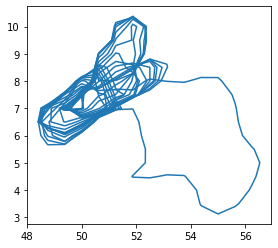

In [56]:
ccvl_2014_05_15_23_lat6p137N.boundary.plot() #.time.values

In [44]:
!ls -atl *son

-rw-r--r--  1 brianmapes  staff   742 Jun 12 00:35 2014_05_15_02_lat9p247N.geojson
-rw-r--r--  1 brianmapes  staff  5968 Jun 12 00:35 Africa_Ecoast_20NS.geojson


<AxesSubplot:>

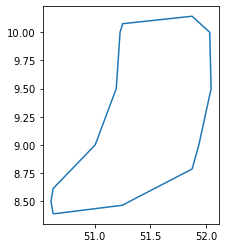

In [45]:
test = gp.read_file('2014_05_15_02_lat9p247N.geojson')
test.boundary.plot()

In [59]:
ccvl_stats

,lasttime,duration,areatime,tqv_values,maxarea
0,2014-05-15 02:00:00,0 days,1.470142,55.0,1.470142
